In [1]:

import numpy as np
import cv2

import pandas as pd
import time

import torch
from torch import nn

In [2]:
from torch.utils.data import Dataset, DataLoader, sampler
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

Loading the tensors and displaying them as images

In [3]:
Imgs = torch.load(r"C:\Users\krish\building-segmentation-tutorial\output\tensors\Imgs.pt")
Msks = torch.load(r"C:\Users\krish\building-segmentation-tutorial\output\tensors\Msks.pt")

In [9]:
Imgs.shape

torch.Size([9457, 256, 256, 4])

In [5]:
Msks.shape

torch.Size([9457, 256, 256])

In [9]:
Imgs[5].shape

torch.Size([256, 256, 4])

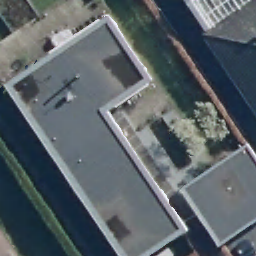

In [19]:
nparr = Imgs[5].detach().cpu().numpy()[:,:,:-1]
Image.fromarray(nparr.astype(np.uint8), 'RGB')


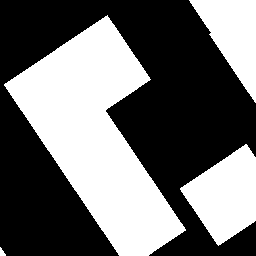

In [7]:
nparr = Msks[5].detach().cpu().numpy().transpose()
Image.fromarray(nparr.astype(np.uint8), 'L')

Using the data to instantiate a subclass of the Dataset class, and using it to create DataLoaders to pass to the model to train.

In [99]:
class patchDataset(Dataset):
    def __init__(self, X, Y):
        super().__init__()
        self.Imgs = X
        self.Msks = Y
        
    def __getitem__(self, idx):
        
        x = self.Imgs[idx].detach().cpu().numpy().transpose((2,0,1))
        x = torch.tensor(x, dtype=torch.float32)
        
        y = Msks[idx].detach().cpu().numpy().transpose()
        y = torch.tensor(y, dtype=torch.float32)
        y = y.type(torch.LongTensor)
        
        return x,y
    
    def getimg(self, idx, mask=False):
        if mask:
            msk = self.Msks[idx].detach().cpu().numpy().transpose()
            m = Image.fromarray(msk.astype(np.uint8), 'L')
            return m
        else:
            img = self.Imgs[idx].detach().cpu().numpy()[:,:,:-1]
            z = Image.fromarray(img.astype(np.uint8), 'RGB')
            return z
    def __len__(self):
        return len(self.Imgs)

In [86]:
dataset = patchDataset(Imgs, Msks)

In [69]:
len(dataset)

9457

In [70]:
x,y = dataset[5555]
x.shape

torch.Size([4, 256, 256])

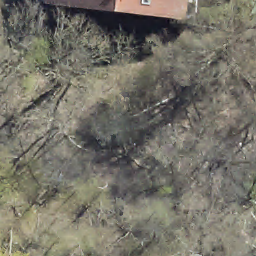

In [71]:
dataset.getimg(5555)

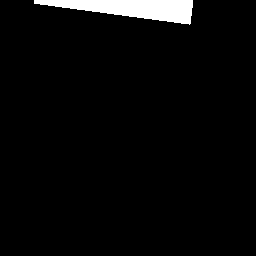

In [72]:
dataset.getimg(5555, mask=True)

In [100]:
train_ds, val_ds, test_ds = torch.utils.data.random_split(dataset, (8000, 1440, 17))
train_dl = DataLoader(train_ds, batch_size=1, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=1, shuffle=True)

In [101]:
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([1, 4, 256, 256]), torch.Size([1, 256, 256]))

The Contract block

In [76]:
def contract_block(in_channels, out_channels, kernel_size, padding):

    contract = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
        torch.nn.BatchNorm2d(out_channels),
        torch.nn.ReLU(),
        torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
        torch.nn.BatchNorm2d(out_channels),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                             )

    return contract

In [77]:
block1 = contract_block(4,32,3,1)

In [78]:
c1 = block1(xb)

In [41]:
c1.shape

torch.Size([8, 32, 128, 128])

The expand block

In [42]:
def expand_block(in_channels, out_channels, kernel_size, padding):

    expand = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
        torch.nn.BatchNorm2d(out_channels),
        torch.nn.ReLU(),
        torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
        torch.nn.BatchNorm2d(out_channels),
        torch.nn.ReLU(),
        torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
    return expand

In [43]:
block2 = expand_block(32,3,3,1)

In [44]:
c2 = block2(c1)
c2.shape

torch.Size([8, 3, 256, 256])

The full model

In [103]:
class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = self.contract_block(in_channels, 32, 7, 3)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)

        self.upconv3 = self.expand_block(128, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, out_channels, 3, 1)

    def __call__(self, x):

        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)

        upconv3 = self.upconv3(conv3)

        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand

The training loop

In [104]:

def train(model, train_dl, valid_dl, loss_fn, optimizer, acc_fn, epochs=1):
    start = time.time()
    model.cuda()

    train_loss, valid_loss = [], []

    best_acc = 0.0

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)  # Set trainind mode = true
                dataloader = train_dl
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = valid_dl

            running_loss = 0.0
            running_acc = 0.0

            step = 0

            # iterate over data
            for x, y in dataloader:
                x = x.cuda()
                y = y.cuda()
                step += 1

                # forward pass
                if phase == 'train':
                    # zero the gradients
                    optimizer.zero_grad()
                    outputs = model(x)
                    loss = loss_fn(outputs, y)

                    # the backward pass frees the graph memory, so there is no 
                    # need for torch.no_grad in this training pass
                    loss.backward()
                    optimizer.step()
                    # scheduler.step()

                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss = loss_fn(outputs, y.long())

                # stats - whatever is the phase
                acc = acc_fn(outputs, y)

                running_acc  += acc*dataloader.batch_size
                running_loss += loss*dataloader.batch_size 

                if step % 10 == 0:
                    # clear_output(wait=True)
                    print('Current step: {}  Loss: {}  Acc: {}  AllocMem (Mb): {}'.format(step, loss, acc, torch.cuda.memory_allocated()/1024/1024))
                    # print(torch.cuda.memory_summary())

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_acc / len(dataloader.dataset)

            print('{} Loss: {:.4f} Acc: {}'.format(phase, epoch_loss, epoch_acc))

            train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    return train_loss, valid_loss    

def acc_metric(predb, yb):
    return (predb.argmax(dim=1) == yb.cuda()).float().mean()

In [115]:
unet = UNET(4,1)

In [118]:
#loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.NLLLoss()
opt = torch.optim.Adam(unet.parameters(), lr=0.01)

In [119]:

train_loss, valid_loss = train(unet, train_dl, val_dl, loss_fn, opt, acc_metric, epochs=20)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [76]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
torch.cuda.is_available()

True

In [7]:
device = torch.device("cuda")

AssertionError: Torch not compiled with CUDA enabled